# Mixture models and expectation maximization

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt
import seaborn as sns

## Tutorial content

1. We will define the mixture of Gaussians in terms of a generative model and use it to simulate data
2. On the example of fitting the mixture model, we will learn about the Expectation Maximization algorithm.

BONUS: We will compare analytical and numerical solutions, which can deal with custom mixture models (e.g., mixture of Gaussian and Student t).

## Experimental setup

In this tutorial, we will work with models that assume that our variable of interest $\boldsymbol{x}$ in different trials is generated by different underlying processes. As an example, we will consider a bandit-like decision making task where the value of each object fluctuates throughout the experiment. Choices are made by making a saccade to one of the three objects on a screen.

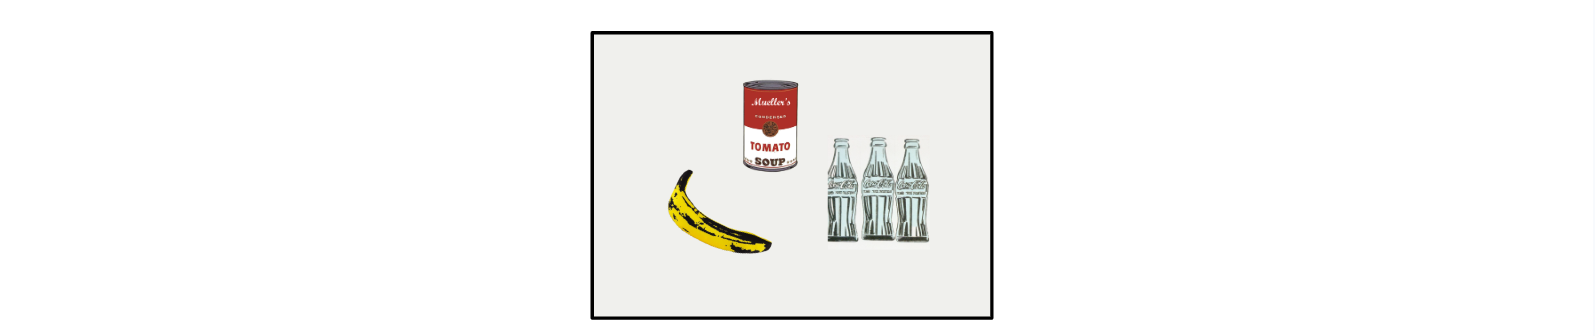

We are interested in analyzing an example subject's trial-by-trial choices through the course of the experiment. We do not have access to explicit choice data (e.g., we might be working with young children), but only to an array of saccade endpoints $\boldsymbol{x} \in \mathbb{R}^{N x D}$, where $N$ is the number of trials, and $D = 2$ the dimensionality of our data, corresponding to horizontal and vertical positions on the display.

## Mixture of Gaussians

We will assume that in each trial, saccades will be centered on the chosen object. However, eye-tracking data is noisy: Therefore, for each of the three object classes $k$ (with $K=3$ : banana, soup, coke), saccades are distributed as 2D Gaussians around the objects.

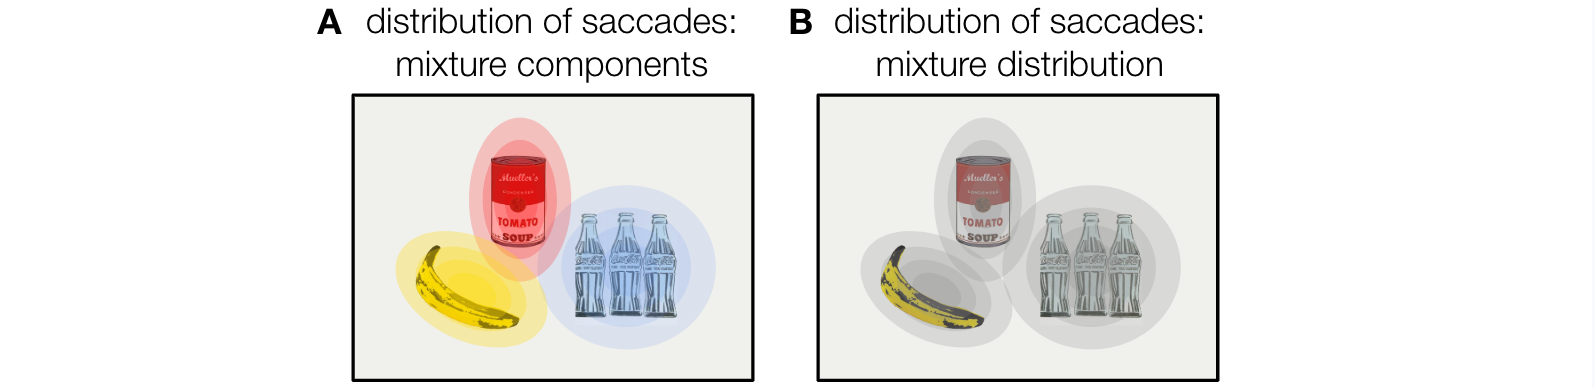

The experimenter of course only has access to 'unlabeled' saccade data as in (B), where for a single trial it is not clear which distribution it was sampled from. The grey density is called a *Gaussian mixture distribution*, which is a weighted sum of the *mixture components* (i.e., the red, yellow, and blue Gaussians in (A)):

\begin{align}
p(\boldsymbol{x}) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x} | \mu_k, \Sigma_k) 
\end{align}<div style="text-align: right"> Eq. (1) </div>

with class- or component-specific means $\mu_k$ and covariances $\Sigma_k$, and *mixing coefficients* $\pi_k$.

# 1. The Gaussian mixture model as a generative model

What does this saccade distribution tell us about underlying cognitive and motor processes?

We can think of the saccade generation as a hierarchical process, with two types of variables:

- The **latent variable** $\boldsymbol{z} \in \{0,1\}^{K\times N}$, which indicates the choice of one of the objects (where $z_{nk} = 1$ if the class in trial $n$ corresponds to $k$). $\boldsymbol{z}$ is *unobserved* or *latent*, and has to be inferred.
- The **observations** $\boldsymbol{x} \in \mathbb{R}^{N\times D}$, which in our task are the 2D saccade endpoints. $\boldsymbol{x}$ depends on $\boldsymbol{z}$, reflected by the directed arrow below.

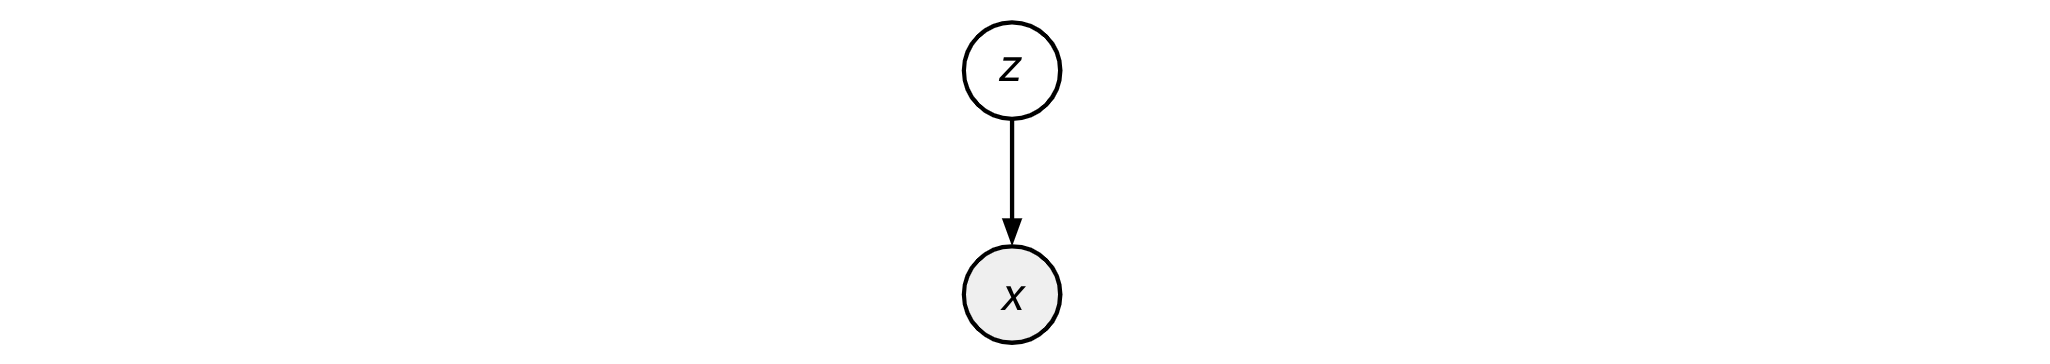

The joint distribution can be written as $p(\boldsymbol{x,z} | \theta) = p(\boldsymbol{x} |\boldsymbol{z}, \theta) p(\boldsymbol{z} | \theta)$, with parameters $\theta = \{\mu, \Sigma, \pi\}$. Marginalizing out $\boldsymbol{z}$ leads us back to Eq. (1).: 

\begin{align}
p(\boldsymbol{x} | \theta) = \sum_Z p(\boldsymbol{x}, \boldsymbol{z} | \theta) = \sum_Z p(\boldsymbol{z} | \theta) p(\boldsymbol{x} |\boldsymbol{z}, \theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x} | \mu_k, \Sigma_k) 
\end{align}

where the prior over $\boldsymbol{z}_k$ is $\pi_{k}$, and the class-conditional distribution $p(\boldsymbol{x} |\boldsymbol{z}, \theta)$ is Gaussian, given the value of $\boldsymbol{z}$: 
$p(\boldsymbol{x} | z_k=1, \theta_k) = \mathcal{N}(\boldsymbol{x}|\mu_k, \Sigma_k)$. In our experiment, the prior would correspond to the average reward probability that the subject infers for each object, while the mean and covariance depend on each object's shape and position, as well as subjects-specific variability in saccade data.
Note that $p(\boldsymbol{x} |\boldsymbol{z},\theta)$ could also follow any other distribution (e.g. Student t, Poisson, Bernoulli, etc.).

We can use the knowledge about the hierarchical structure to simulate a dataset by randomly sampling $\boldsymbol{x}$ in $N = 1000$ trials from Eq. 1. We will assume for now that the subject chooses a random object in each trial, only based on prior probabilities $\pi_k$.

## 1.1. Ground truth parameters

In [2]:
# Hyperparameters
N = 1000
K = 3
D = 2

# screen borders
borders = np.array([[0,80], [0,60]])

# mixing coefficients: should sum to 1 so that if each mixture component is a density, 
# the full mixture distribution is also a density
pis = [.2, .35, .45]

# mus
mus = [np.array([20,20]), np.array([35,40]), np.array([60,25])]

# pick DxD covariance matrices for each Gaussian
# symmetric with small covariances to ensure they are positive semidefinite
sigmas = [20*np.array([[1,-.4],[-.4,1]]), 
          40*np.array([[.5,0],[0,1]]), 
          40*np.array([[1,.1],[.1,1]])]

# set random seed for reproducibility
np.random.seed(0)

## 1.2. True values of latent variable $\boldsymbol{z}$

For each trial, simulate the subject's true choices. Create
- a vector `ks` of length $N$ encoding the classes, i.e. with values in $\{0,1,2\}$. Use `np.random.choice()`
- `zs`, i.e. the true value of the latent variable $\boldsymbol{z} \in \{0,1\}^{K \times N}$

Plot $\boldsymbol{z}$ over the first 100 trials.

In [3]:
# make vector of true class identities

# make K x N array for true values of z


Text(0.5, 1.0, 'true value of latent variable $z_{nk}$')

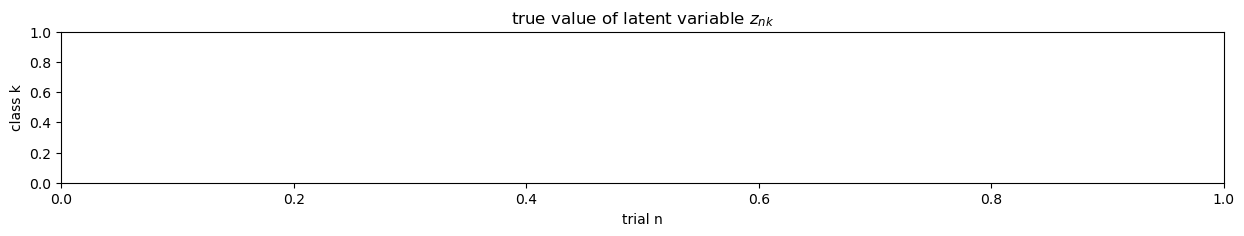

In [4]:
plt.figure(figsize=(15,2), dpi=100)

# plotting code here

plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

## 1.3. Sample observations $\boldsymbol{x}$

Sample $N=1000$ saccades from a class-specific multivariate Gaussian (i.e., a Gaussian with class-specific parameters `mu` and `sigmas`), using the function `sps.multivariate_normal.rvs()`. Note that for our code, it is usually easier to us `ks` as a class index than `zs`.

Plot the empirical distribution of saccades by uncommenting the pre-written code.

In [5]:
# simulate saccades depending on k_n


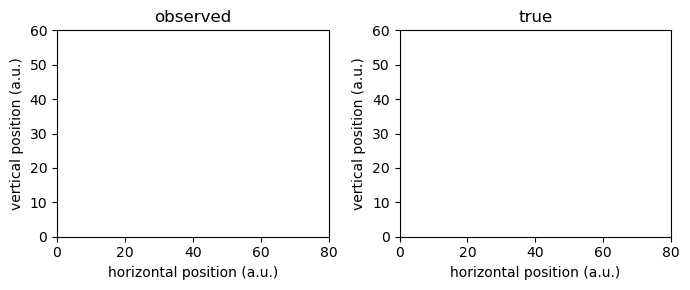

In [6]:
# plot data
colors = ['y', 'r', 'b']

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
# plt.scatter(saccades[:,0], saccades[:,1], c='k', alpha=.05)
# for mi,m in enumerate(mus):
#     plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('observed')

plt.subplot(1,2,2)
# plt.scatter(saccades[:,0], saccades[:,1], 
#             c=[colors[k] for k in ks], alpha=.05)
# for mi,m in enumerate(mus):
#     plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('true')
plt.tight_layout()

# 2. Fitting Gaussian mixture models

We will now turn to the question of how to infer the latent variable $\boldsymbol{z}$ from the observations $\boldsymbol{x}$. In order to do so, we need an estimate of the number of mixture components $K$, and a statistical description of each component. In our task, we assume that $K = 3$. We will also assume that for each class $k$, observations are sampled from a Gaussian distribution. Thus, our inference problem concerns the estimation of 
- the values of latent variable $\boldsymbol{z_n}$ for each observation $x_n$ (i.e., the most likely class)
- parameters $\theta_k = \{\mu_k, \Sigma_k, \pi_k$\} for each component $k$.

Importantly, we cannot infer these parameters and variables independently of each other. E.g., to be able to judge whether a data point belongs to a certain point cloud, we first need a good estimate of the center (and covariance) of that cloud. Vice versa, in order to estimate the center of a point cloud, we need to define which points we think belong to it. *Iterative algorithms* like **expectation maximization (EM)** solve this entangled optimization problem by dividing it into two sub-problems.

<div class="alert alert-block alert-info"> <b>The expectation maximization (EM) algorithm</b> 

Expectation maximization (EM) iteratively updates estimates of 1) the *posterior* for the latent variables (here, which class a sample belongs to), and 2), the optimal model parameters (i.e., finding maximum likelihood estimates). The steps in the EM algorithm are:


0. **Initialization**: Choose model parameters $\theta^{0}$ for iteration $i = 0$.
1. **E step: Best guess for values of the latent variable $\boldsymbol{z}$.** \
   Formally, this corresponds to calculating the *expected values* $\mathbb{E}[\boldsymbol{z}]$ under the posterior $p(\boldsymbol{z} | \boldsymbol{x}, \theta^i)$, where $\mathbb{E}[\boldsymbol{z}] \in [0,1]^{N,K}$. \
   Note: $\mathbb{E}[z_{nk}]$ is the probability of data point $n$ belonging to category $k$, while $z_{nk}$ indicates the true category and is therefore binary (0 or 1).
2. **M step: Update parameters $\boldsymbol{\theta}^{ i+1}$ by maximizing the likelihood.** \
   We would like to maximize the *complete-data log likelihood* $\ln p(\boldsymbol{x},\boldsymbol{z} | \theta)$ of observing $\boldsymbol{x}$ and $\boldsymbol{z}$, given the parameters $\theta$. However, $\boldsymbol{z}$ is unknown. \
   Instead, we will find the parameters $\theta^{i+1}$ that maximize the *expected value* of the complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ under the posterior of $\boldsymbol{z}$, $p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i})$. This expected value can be written as
   
   \begin{align}
   \mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)] &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)
   \end{align}

E and M steps are alternated iteratively until the log likelihood converges. It is advisable to run the algorithm several times with distinct initializations (0.) and pick the model with the highest log likelihood.
    
</div>

## 2.1. Initialization

In the Gaussian mixture model, we initialize three parameters for each mixture component: $\theta = \{\mu,\Sigma, \pi\}$.

Write a function that randomly initializes parameters (within certain bounds, i.e. screen boundaries for $\mu$. For $\Sigma$, choose positive diagonal entries and off-diagonal entries that are zero). 

Plot the resulting mixture distribution by evaluating the joint distribution (Eq. 1) at uniformly spaced values of $x$ (pre-coded as `vals`). Remember that $\mathcal{N}(x; \mu, \Sigma)$ can be evaluated by calling `sps.multivariate_normal.pdf(x, mu, sigma)`.

In [7]:
# function to initialize the GMM
def initialize_GMM(K, D, lower, higher):
    
    # initialize means to random integers
    
    # initialize covariance to random integer on diagonal, 0 off-diagonal
    
    # pick random numbers that sum to 1
    
    return m, s, p

In [8]:
# pick random means, covariances, and mixing coefficients


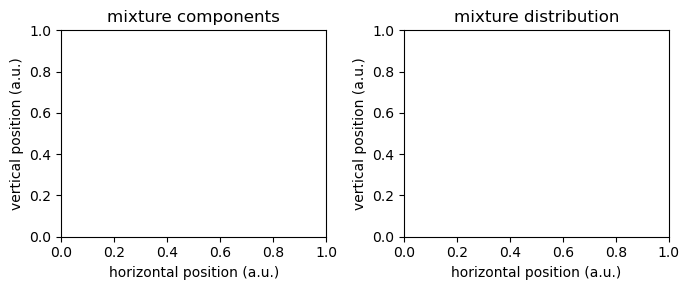

In [9]:
# plot initial means and covariances, as well as initial mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs at 'vals'

# sum weighted pdfs for mixture distribution

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
# for k,pdf in enumerate(pdfs):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
# plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

## 2.2. E Step

Given the parameters at iteration $i$, $\theta^{i}$, and observations $\boldsymbol{x}$, what is the posterior distribution $p(\boldsymbol{z} | \boldsymbol{x}, \theta^i)$ and its expected value $\mathbb{E}[\boldsymbol{z}]$?

<div class="alert alert-block alert-info"> <b>Calculating the posterior</b> 
    
Following Bayes theorem, we can write the posterior as:

\begin{align}
p(\boldsymbol{z}|\boldsymbol{x},\theta) &= \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{p(\boldsymbol{x} | \theta)} 
                = \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{\sum_Z p(\boldsymbol{x}, \boldsymbol{z} | \theta)} 
                = \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{\sum_Z p(\boldsymbol{x} | \boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}
\end{align}

</div>

For Gaussian mixtures, this translates to calculating the probability $p(z_{nk}=1|\boldsymbol{x}_n, \theta^{i})$ that observation $x_n$ in trial $n$ was sampled from distribution $k$ with parameters $\theta_k^{i} = \{\mu_k^i, \Sigma_k^i, \pi_k^i\}$ for iteration $i$. These probabilities are the expected values $\mathbb{E}[z_{nk}]$ of the posterior and are called the *responsibilities* $\gamma_{nk}$.

\begin{align}
\gamma_{nk} = p(z_{nk}=1|\boldsymbol{x}_n, \theta)
            = \frac{\pi_k\mathcal{N}(\boldsymbol{x}_n|\mu_k, \Sigma_k)}{\sum^K_{j=1}\pi_j\mathcal{N}(\boldsymbol{x}_n|\mu_j, \Sigma_j)} 
\end{align}<div style="text-align: right"> Eq. (2) </div>

Write a function `GMM_estep(x, mu, sigma, pi)` that implements Eq. (2) to compute the responsibilities $\gamma_{nk}$.

In [10]:
def GMM_estep(data, m, s, p):
    K = m.shape[0]
    
    # joint p(x,z) = p(z)*p(x|z): prior * likelihood (evaluate pdf at each x_n). Should be K x N shaped
    
    # marginal likelihood p(x) = sum_z( p(x,z) ) sum joint over K classes. vector of length N
    
    # posterior: p(x,z) / p(x)

    return posterior

In [11]:
# calculate gammas (call E Step)


Text(0.5, 1.0, 'expected value of the posterior $E_z[z_{nk}]$')

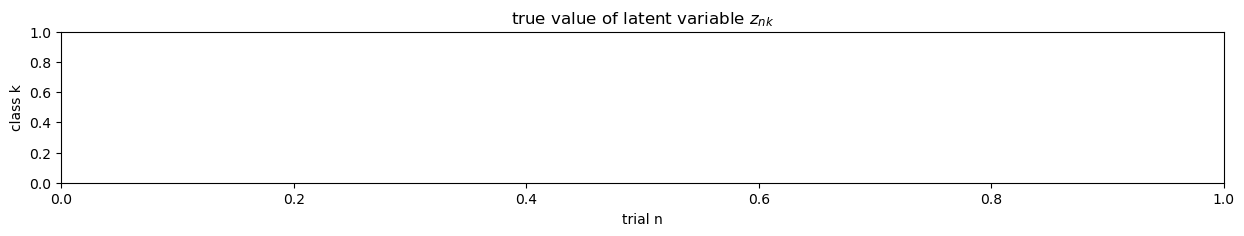

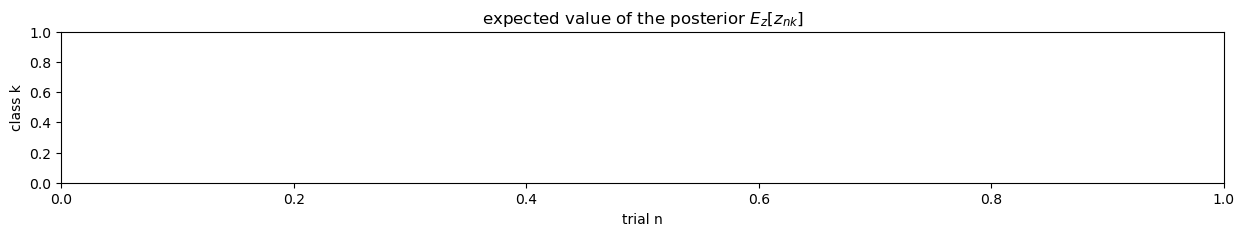

In [12]:
# plot
plt.figure(figsize=(15,2), dpi=100)
# plt.imshow(zs[:,:100], aspect='auto', interpolation='none', cmap='magma')
# plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

plt.figure(figsize=(15,2), dpi=100)
# plt.imshow(gammas[:,:100], aspect='auto', interpolation='none', cmap='magma')
# plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'expected value of the posterior $E_z[z_{nk}]$')

## 2.3. Log likelihood

Ideally, we would now update parameters that maximize the complete-data log likelihood $\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)$, but we don't know the true values of $\boldsymbol{z}$. Therefore, we calculate its expected value $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ under the posterior $p(\boldsymbol{z} | \boldsymbol{x}, \boldsymbol{\theta}^{i})$:

<div class="alert alert-block alert-info"> <b>Expected complete-data log likelihood</b> 

\begin{align}
  \mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)] &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln p(\boldsymbol{x}, \boldsymbol{z}| \theta) \\
   &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln \{ p(\boldsymbol{x} | \boldsymbol{z}, \theta) p(\boldsymbol{z} | \theta) \}
   \end{align}

</div>
<div style="text-align: right"> Eq. (3) </div>

where we will plug in the expected values of the posterior $\gamma_{nk} = p(z_{nk} = 1 | \boldsymbol{x}_n, \theta^i_k)$ calculated in the E Step. Moreover, as before, $p(z_{nk} = 1 | \theta_k) = \pi_k$ and $p(\boldsymbol{x}_n | z_{nk} = 1, \theta_k) = \mathcal{N}(\boldsymbol{x}_n ; \mu_k, \Sigma_k)$. 

Write a function that takes the data, $\gamma$, and parameters $\theta^{i}$ and computes the expected log likelihood given by Eq. (3). To get back a scalar, sum the log likelihood over all datapoints after summing over classes.

*Tip*: If calculating log probabilities gives you `-inf`, you can use the function `np.nan_to_num(logprob, nan=np.nan, posinf=np.inf, neginf=-1e10)` that replaces `-inf` with very large negative numbers.

In [13]:
# log likelihood function
def GMM_log_LL(data, gammas, m, s, p):
    K = len(m)
    
    # first: evaluate LL p(x|z), i.e. evaluate the pdf for each of the K components. Should be K x N shaped

    
    # multiply LL by prior and take log: log (p(x|z) * p(z)) . Still K x N shaped
    # then: multiply by gammas, E[z] * log (p(x|z) * p(z)) . also K x N shaped
    
    # sum whole expression over K
    
    # sum log likelihood of N single data points
    
    return LL

In [14]:
# call LL function to evaluate

## 2.4. M Step

The M-step consists of re-estimating parameters $\theta^{i+1} = \{\mu^{i+1}, \Sigma^{i+1}, \pi^{i+1}\}$ that maximize this log likelihood function. We could tackle this parameter optimization problem by calling `spo.minimize()`, where our loss function would be the negative log likelihood, and our parameter vector a concatenation of all values in `mu, sigma` and `pis`. However, mixtures of Gaussians allow for faster and more robust parameter updates with the analytical solution.

To find parameters that maximize the expected complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$, we set its derivative w.r.t. $\mu_k$, $\Sigma_k$, or $\pi_k$ to zero. From that, we get closed-form solutions

\begin{align}
\mu_k  &= \frac{1}{N_k} \sum^N_{n=1} \gamma_{nk} x_n \\
\Sigma_k &=  \frac{1}{N_k} \sum^N_{n=1} \gamma_{nk} (x_n-\mu_k)(x_n-\mu_k)^T \\
\pi_k &= \frac{N_k}{N}
\end{align}<div style="text-align: right"> Eq. (4-6) </div>


where $N_k$ is defined as $N_k = \sum^N_{n=1} \gamma_{nk}$. Write a function to update the parameters using Eqs. (4-6).

In [15]:
def GMM_mstep(data, g):
    K = g.shape[0]
    N = g.shape[1]
    D = data.shape[-1]

    # class-specific normalization constant: sum gammas over N
    
    # mu: weight each of N data points by its gamma, then sum over N and normalize with N_k

    
    # Sigma: K covariances of shape D x D
    s = np.zeros([K,D,D]) * np.nan
    
        # for each class k and each sample n, 
        # take the dot product (x_n - mu_k) @ (x_n - mu_k).T
        # sum over N

    # pi
        
    return m, s, p

In [16]:
# update mu, sigma, and pi parameters


## 2.5. full EM algorithm

Write a loop that runs EM steps 1. and 2. iteratively for 50 iterations. Repeat the algorithm for five different random initializations. 

Evaluate the expected complete-deta log likelihood at each iteration and plot the progress of log likelihoods over iterations for each initialization.

In [17]:
# save parameters and likelihoods
model = []
LLs = []

# several random initializations

    # pick random means, covariances, and mixing coefficients

    # single E step to evaluate initial LL

    
    # iterate 50 times
    
        # E Step
        
        # M Step
        
        # Likelihood

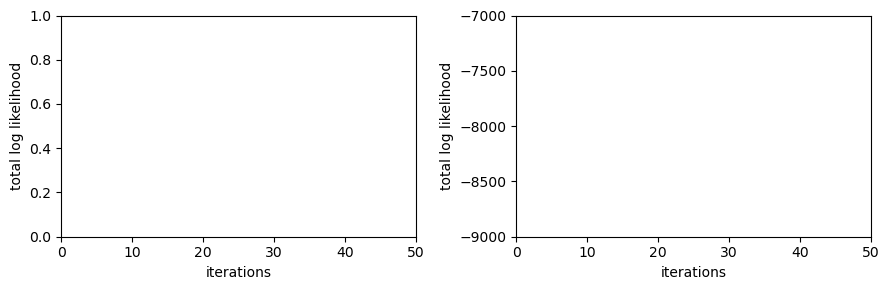

In [18]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)

# plot LL

plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)

# same thing zoomed-in 
plt.subplot(1,2,2)

# plot LL 

plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.ylim(-9000, -7000)
plt.tight_layout()

## 2.6. Model validation

Select the model with the highest final log likelihood. Plot true vs. estimated densities of single mixture components, as well as the full mixture distribution.

In [19]:
# select best model


Text(0.5, 1.0, 'expected value of the posterior $E_z[z_{nk}]$')

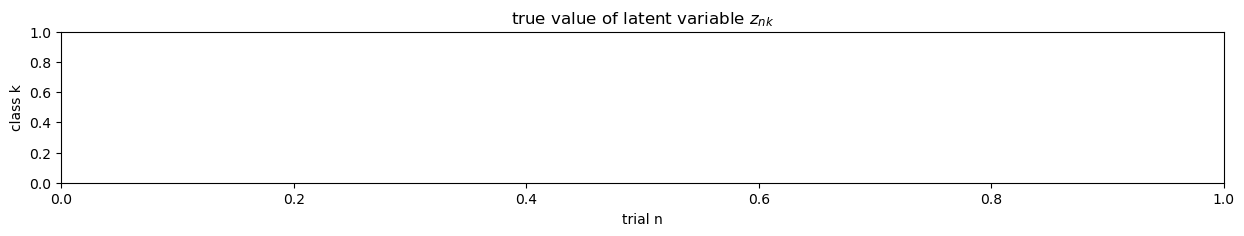

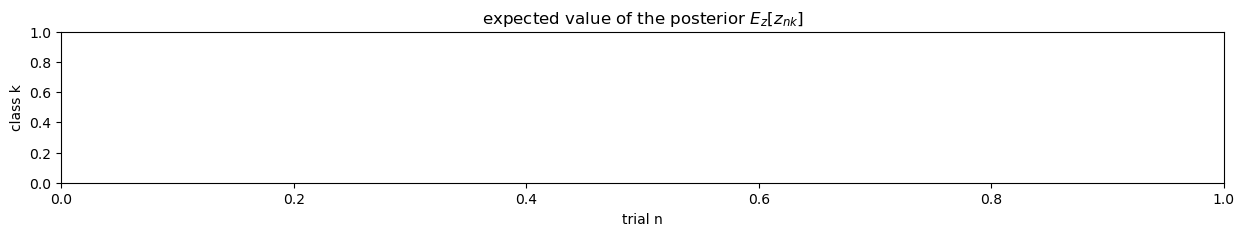

In [20]:
# plot true values of z (first 100 trials) and expected values of the posterior (first 100 trials)

plt.figure(figsize=(15,2), dpi=100)
# plt.imshow(zs[:,:100], aspect='auto', interpolation='none', cmap='magma')
# plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

plt.figure(figsize=(15,2), dpi=100)
# plt.imshow(g[:,:100], aspect='auto', interpolation='none', cmap='magma')
# plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'expected value of the posterior $E_z[z_{nk}]$')

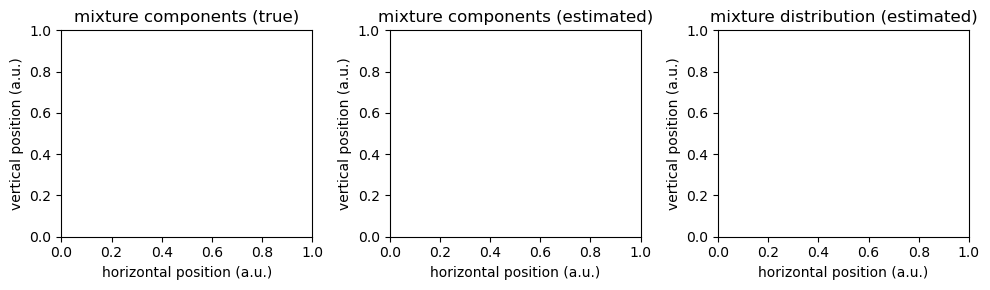

In [21]:
# plot final means and covariances, as well as final mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs

# sum weighted pdfs for mixture distribution

# true pdfs

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
# for k,pdf in enumerate(pdfs_true):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,2)
# for k,pdf in enumerate(pdfs):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,3)
# plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

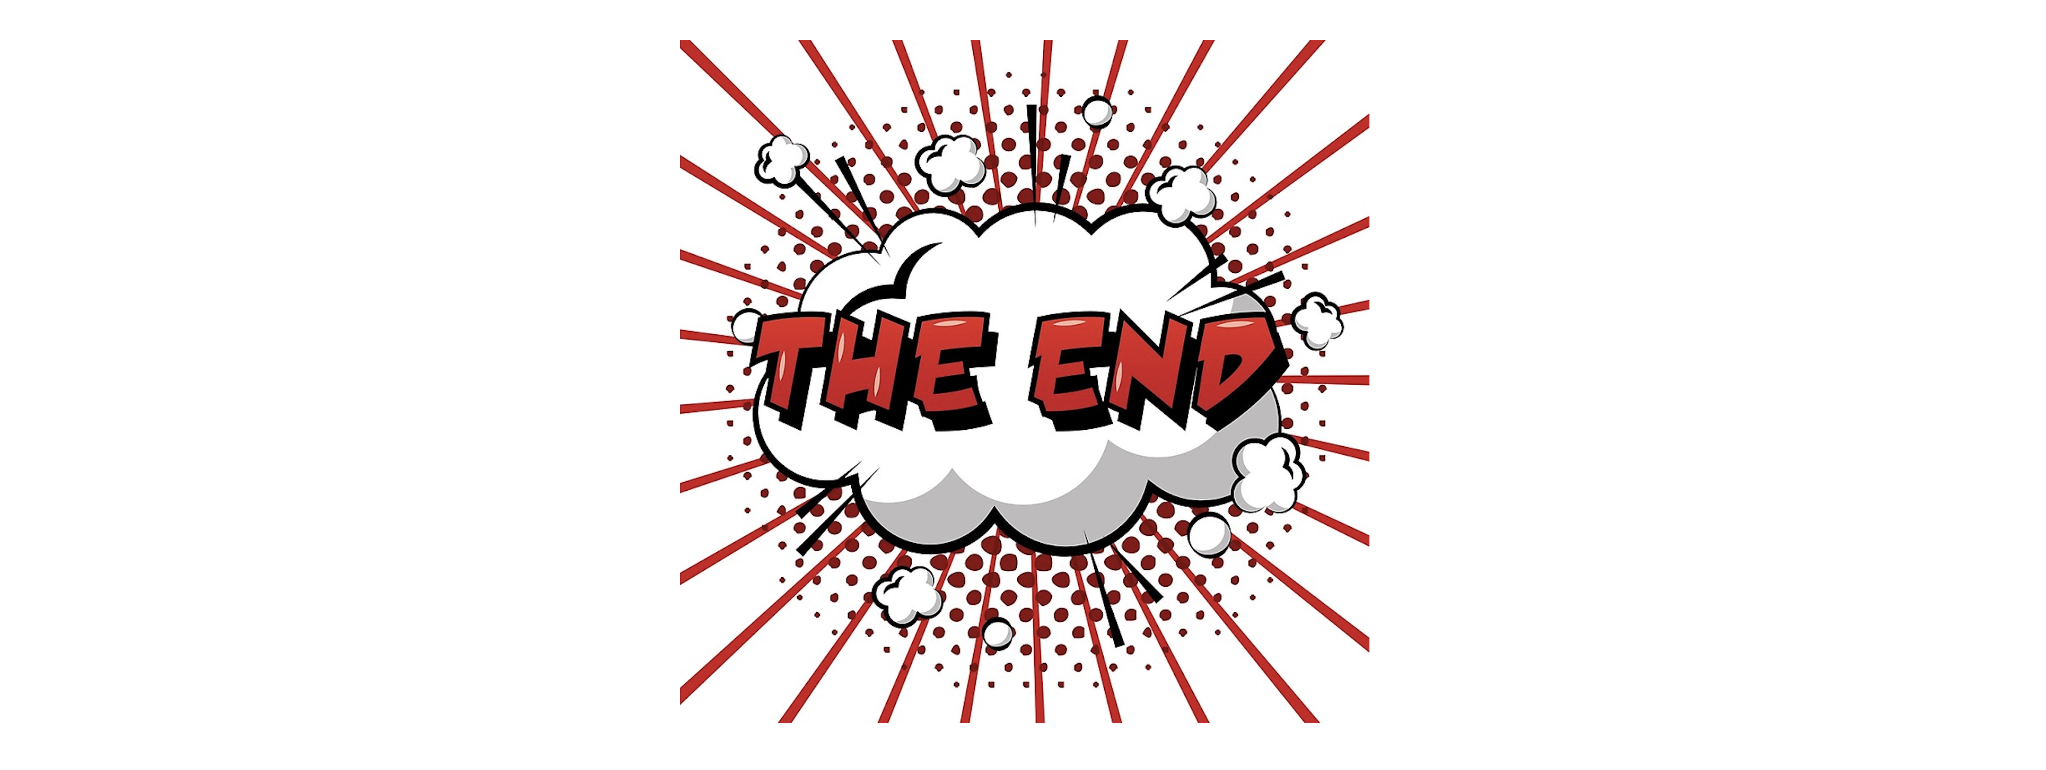

## What to do if there's no analytical solution (or we don't want to derive it)?

In the maximization step, we updated parameters to the maximum likelihood solution, which is obtained by setting the derivative of the log likelihood function $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ w.r.t. each parameter to zero and solving for the parameter of interest.

However, we could also use a less elegant, but sometimes more practical solution, where parameters are optimized numerically with `spo.minimize()` or similar methods. In the following, you can see an alternative implementation of the M-step. Note that parameter bounds help in finding stable solutions.

Numerical solutions are more flexible and can be used when it is difficult to obtain closed-form solutions.

In [22]:
def neg_log_LL(pars, data, g, p, D, K):
    
    # reconstruct K x D array of means
    m = pars[:K*D].reshape(K,D)
    
    # reconstruct K x D x D array of covariance matrices
    s_triu = pars[K*D:].reshape(K,-1)
    s = np.zeros([K,D,D]) * np.nan
    
    for k in range(K):
        s[k][np.triu_indices(D)] = s_triu[k]
        s[k][np.tril_indices(D)] = s_triu[k]

        if sum(np.sum(np.abs(np.triu(s[k], k=1)), axis=0) > np.min(np.diag(s[k]))) > 0:

            s[k][np.triu_indices(D, k=1)] = 0
            s[k][np.tril_indices(D, k=-1)] = 0   
      
    nlogLL = -GMM_log_LL(data, g, m, s, p)
    
    return nlogLL


def GMM_numerical_mstep(data, g, m, s, p):
  
    K = m.shape[0]
    D = m.shape[1]

    # update pis
    p = np.mean(g, axis=1)
    
    m_reshape = m.reshape(-1)
    s_triu = np.array([s[k][np.triu_indices(D)] for k in range(K)])
    s_reshape = s_triu.reshape(-1)
    
    x_start = np.concatenate([m_reshape, 
                              s_reshape])
    
    # set bounds
    bds = np.concatenate([
                          [(0,100)]*len(m_reshape), # bounds on mean at dim 1 and dim 2
                          [(1,200), (-200,200), (1,200)]*K # variance, covariance, variance
                          ])
    
    # call spo.minimize() on negative LL
    res = spo.minimize(neg_log_LL, 
                       x0=x_start, bounds=bds, 
                       args=(data, g, p, D, K),
                       method='L-BFGS-B') #'SLSQP')
    
    newpars = res.x
    
    # reconstruct K x D array of means
    m = newpars[:int(K*D)].reshape(K,D)
    
    # reconstruct K x D x D array of covariance matrices
    s_triu = newpars[K*D:].reshape(K,-1)
    s = np.zeros([K,D,D]) * np.nan
    
    for k in range(K):
        s[k][np.triu_indices(D)] = s_triu[k]
        s[k][np.tril_indices(D)] = s_triu[k]
        
        if sum(np.sum(np.abs(np.triu(s[k], k=1)), axis=0) > np.min(np.diag(s[k]))) > 0:
            s[k][np.triu_indices(D, k=1)] = 0 #/= 2
            s[k][np.tril_indices(D, k=1)] = 0 #/= 2

    return m, s, p

In [29]:
model = []
LLs = []

# # several random initializations
# for init in range(5):

#     # pick random means, covariances, and mixing coefficients

#     # initial E step to evaluate LL

#     # iterate 50 times



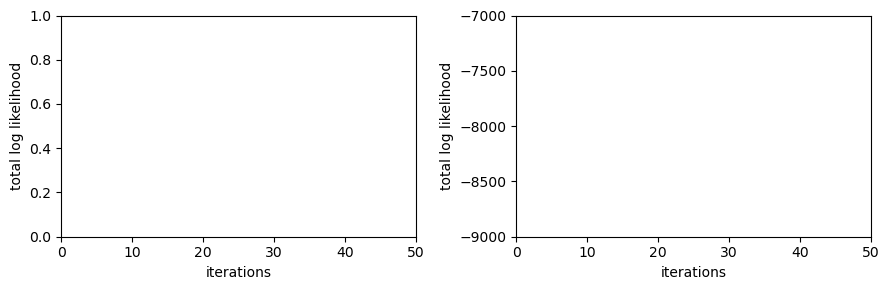

In [30]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)
# plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.subplot(1,2,2)
# plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.ylim(-9000, -7000)
plt.tight_layout()

In [28]:
# select best model


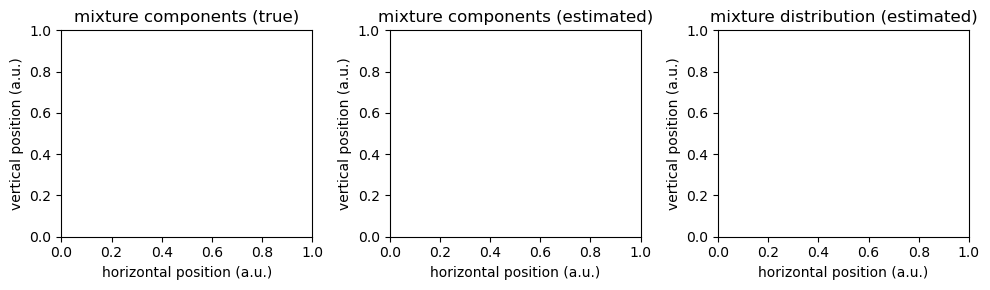

In [31]:
# plot initial means and covariances, as well as initial mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs

# sum weighted pdfs for mixture distribution

# true pdfs
pdfs_true = [sps.multivariate_normal.pdf(vals, mus[k], sigmas[k]) for k in range(K)]

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
# for k,pdf in enumerate(pdfs_true):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,2)
# for k,pdf in enumerate(pdfs):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,3)
# plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

## Custom mixtures

We could easily customize our mixture model to incorporate different mixture distributions than Gaussians, for example a Student-t distribution. Here, the center of the object would have a higher saccade density, whereas the margins of the saccade distribution seem to be flatter.

We could model a mixture of one Student-t component and two Gaussian components:

\begin{align}
p(\boldsymbol{x}) = \pi_{1} \mathcal{N}(\boldsymbol{x} | \mu_1, \Sigma_1) + \pi_{2} \mathcal{N}(\boldsymbol{x} | \mu_2, \Sigma_2) + \pi_{3} \mathcal{St}(\boldsymbol{x} | \mu_3, \Sigma_3, \nu)
\end{align}

The Student-t distribution $\mathcal{St}(\boldsymbol{x} | \mu, \Sigma, \nu)$ has parameters $\mu$ and $\Sigma$, just like the Gaussian, and an additional parameter $\nu \in \mathbb{R}_{+}$ (called degrees of freedom). For $\nu\to\infty$, the Student-t distribution becomes a Gaussian, while it is significantly more "peaked" with flat margins for $\nu\to0$. You can evaluate its probability density function by calling `sps.multivariate_t.pdf(x, mu, sigma, nu)`.

In [32]:
# degrees of freedom parameter
nu = .9

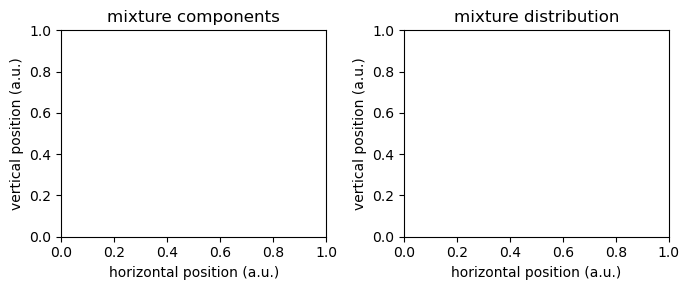

In [34]:
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate Gaussian pdfs

# add Student t pdf

# first component is Student t, others are Gaussian


# sum weighted pdfs for mixture distribution

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
# for k,pdf in enumerate(pdfs):
#     plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
# plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()